# 训练及测试
本笔记本将调用hw1/hw2以作出训练结果，亦可直接导出训练代码供使用。

首先，引入必要的依赖。
TODO：删去opencv

In [135]:
import cv2, matplotlib, scipy.ndimage
import numpy as np
import numpy.linalg as npMat
import matplotlib.pyplot as plt

import sys, os, time

import hw1, hw2

In [136]:
datasetConfig = {1: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10,
    11: 10, 12: 10, 13: 10, 15: 10, 16: 10, 17: 10, 18: 10, 22: 10, 23: 10,
    24: 10, 25: 10, 26: 10, 27: 10}
hw2Config = {0: lambda x: x, 1: hw2.median_filter, 2: lambda x: hw2.liner_filter(x, hw2.mean_filter_generator(3)), 
    3: lambda x: hw2.liner_filter(x, hw2.gaussian_filter_generator(3, 1.5))}

def read_from_dataset(hw1Var = 1, hw2Var = 1) -> list:
    '''This function implements read process, and process data with colorspace transform and filter.

    hw1Var 0=rgb, 1=weighted_mean_grey, 2=mean_grey, 3=max_grey

    hw2Var 0=no_change, 1=median_filter, 2=mean_filter(3*3), 3=gaussian_filter(3*3, 1.5)

    ret list(np.array)

    in case of 
    '''
    imReturn = []
    imShapeReturn = []
    for i, jlim in datasetConfig.items():
        imAll = None
        for j in range(1, jlim + 1):
            try:
                imFile = './dataset/s{}/s{}_{}.jpg'.format(i, i, j)
                imMatrix = cv2.imread(imFile)
                imMatrix = hw1.colorSpaceMatrix(BGR = imMatrix).space[hw1Var] # default: Convert to Grey with weighted mean.
                imMatrix = hw2Config[hw2Var](imMatrix) # default: With the process of Median Filter
                if isinstance(imAll, np.ndarray):
                    try:
                        imAll = np.append(imAll, [imMatrix], axis=0)
                    except ValueError:
                        print("[INFO] Append Error when i = {}, j = {}.".format(i, j)) # e.g.image's height and width isn't identical to the first one.
                else:
                    imAll = np.array([imMatrix])
            except Exception as e:
                print("[INFO] {} Error when i = {}, j = {}".format(e, i, j))
        # TIP not implemented in matlab
        imShapeReturn.append([imAll.shape[1], imAll.shape[2]])
        imAll.resize((imAll.shape[0], imAll.shape[1] * imAll.shape[2])) # shrink dimension, see doc for reasons
        imReturn.append(imAll)
    return imReturn, imShapeReturn

In [137]:
im, imShape = read_from_dataset()
print(imShape)

[[602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402], [602, 402]]


## 降维

PCA 的核心步骤：计算主成分（特征值更大的特征向量），然后通过矩阵相乘 $P \cdot A$ 得 $Q$ 。

其中阐述原理：方便你的方差计算、协方差计算，so作中心化 / 零均值化。注意不是归一化。

补充分析：主成分贡献率，配图。（特征向量即可。无法直接解算原构成，但第一个特征向量似乎有点特殊）

目前基于 https://www.cnblogs.com/mickeyyang/p/13262472.html 实现。

[(10, 242004), 602, 402]: [9.61164129e+09 2.45723719e+09 9.38681684e+08 6.45717197e+08
 4.50739523e+08 1.34664881e+08 1.54724079e+08 3.52111093e+08
 2.97862132e+08 2.39781008e+08]


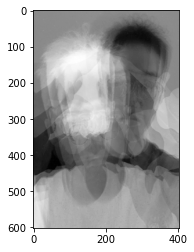

In [138]:
imageFeature = im[17]
print(str([im[21].shape] + imShape[21]) + ": ", end='')
matMean = imageFeature - np.tile(imageFeature.mean(1), (imageFeature.shape[1], 1)).T # TIP not implemented in matlab
# matOne = imageFeature / np.linalg.norm(imageFeature.mean(1), axis = 0) # TIP not implemented in matlab
# matMean = matMean.astype(np.uint8)
# matCovaiance = np.dot(matMean, matMean.T) # only after zero-mean
# matCovaiance = np.cov(matMean.T) # only after zero-mean
matMiddle = np.dot(matMean, matMean.T)
eigValue, eigPreVector = npMat.eig(matMiddle)
# print(matMiddle, eigNormalizedVector)
eigVector = np.dot(imageFeature.T, eigPreVector) / eigValue
# print(matMean, eigValue, eigPreVector, eigVector)
processMat = np.dot(imageFeature, eigVector)
print(eigValue)
# matplotlib.pyplot.imshow(npMat.lstsq(eigVector[:, 0], processMat[0][0]).reshape(imShape[0], imShape[1]))
# temp = (np.tile(processMat[5][5], eigVector.shape[0]) / eigVector[:, 0]).reshape((imShape[5][0], imShape[5][1]))
temp = (eigVector[:, 1]).reshape((imShape[21][0], imShape[21][1]))
plt.imshow(temp, cmap = plt.get_cmap('Greys'))
# temp = (np.tile(processMat[1][1], eigVector.shape[0]) / eigVector[:, 1]).reshape((imShape[5][0], imShape[5][1]))
# plt.imshow(temp, cmap = plt.get_cmap('Greys'))
# temp = (np.tile(processMat[2][1], eigVector.shape[0]) / eigVector[:, 1]).reshape((imShape[5][0], imShape[5][1]))
# plt.imshow(temp, cmap = plt.get_cmap('Greys'))
# print((np.tile(processMat[0][0], eigVector.shape[0]) / eigVector[:, 0]))

In [139]:
imageFeature = np.reshape(im, (len(im) * im[0].shape[0], im[0].shape[1]))
matMean = imageFeature - np.tile(imageFeature.mean(1), (imageFeature.shape[1], 1)).T # TIP not implemented in matlab
matMiddle = np.dot(matMean, matMean.T)
eigValue, eigPreVector = npMat.eig(matMiddle)
eigVector = np.dot(imageFeature.T, eigPreVector) / eigValue
processMat = np.dot(imageFeature, eigVector)
print(eigValue)

[ 7.06139307e+10  2.62922523e+10  1.89437071e+10  1.15368490e+10
  8.82371553e+09  6.39882855e+09  4.78839269e+09  4.29858561e+09
  3.86057390e+09  3.03310624e+09  2.78222650e+09  2.65278649e+09
  2.47196563e+09  2.08209275e+09  1.84347431e+09  1.73346259e+09
  1.64741685e+09  1.50952083e+09  1.40794142e+09  1.28023740e+09
  1.22210429e+09  1.21372517e+09  1.14315722e+09  1.06044686e+09
  9.49432935e+08  9.36845484e+08  9.04811398e+08  8.71591419e+08
  8.38989599e+08  7.82321803e+08  7.20582530e+08  6.84430922e+08
  6.63854170e+08  6.49998061e+08  6.29326046e+08  5.85461849e+08
  5.83279667e+08  5.69588871e+08  5.61801250e+08  5.35959649e+08
  5.14146805e+08  4.99298239e+08  4.63676222e+08  4.54566066e+08
  4.51573068e+08  4.32611662e+08  4.21766748e+08  4.13336612e+08
  4.00897180e+08  3.86672081e+08  3.71361723e+08  3.58707590e+08
  3.59105712e+08  3.47225023e+08  3.41000510e+08  3.26566376e+08
  3.22181488e+08  3.18932552e+08  3.08935877e+08  3.03658502e+08
  2.99760404e+08  2.95502

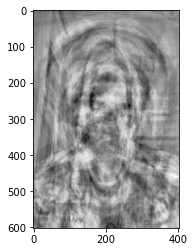

In [140]:
np.savetxt("kernel.csv", eigValue, delimiter=',')
np.savetxt("result.csv", processMat, delimiter=',')
temp = (eigVector[:, 60]).reshape((imShape[21][0], imShape[21][1]))
plt.imshow(temp, cmap = plt.get_cmap('Greys'))